<a href="https://colab.research.google.com/github/cyFou/testColab/blob/main/ia2thor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source du tuto
https://levelup.gitconnected.com/building-a-perfect-million-parameter-llm-like-chatgpt-in-python-3b16e26b4139


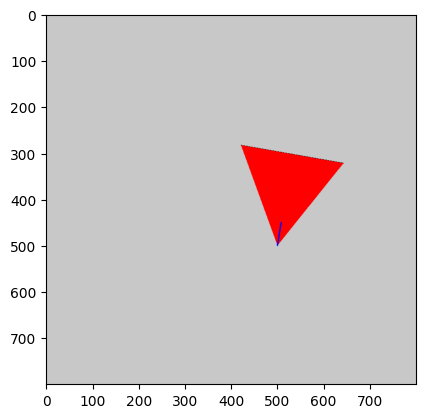

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from skimage.draw import polygon
from skimage.draw import polygon_perimeter


MAP_SCALE = 100        # px/m
MAP_SIZE = 800         # taille carte en px

def world_to_map(x, z):
    """Convertir coordonnées monde -> pixels carte"""
    px = int(MAP_SIZE // 2 + x * MAP_SCALE)
    pz = int(MAP_SIZE // 2 - z * MAP_SCALE)
    return px, pz

occupancy_grid = np.ones((MAP_SIZE, MAP_SIZE), dtype=np.int8) * -1

def draw_map():
    """Convertir la grille d’occupation en image affichable"""
    img = np.zeros((MAP_SIZE, MAP_SIZE, 3), dtype=np.uint8)
    img[occupancy_grid == -1] = (200, 200, 200)  # inconnu
    img[occupancy_grid == 0] = (255, 0, 0)  # libre
    img[occupancy_grid == 1] = (0, 0, 0)        # obstacle

    return img

px = 1
pz = -1
zy = -10

# Matrice de rotation autour de Y (dans le plan XZ)
world_matrix = np.array([
        [np.cos(math.radians(zy)), -np.sin(math.radians(zy)),px],
        [np.sin(math.radians(zy)),  np.cos(math.radians(zy)),pz],
        [0,0,1]
    ])

map_matrix =([
    [MAP_SCALE,0,MAP_SIZE // 2],
    [0,-MAP_SCALE,MAP_SIZE // 2],
    [0,0,1]
    ])

clip_distance_max = 5
nbP = 200
lidar = np.ones(nbP) * 2.0
# lidar = np.random.uniform(low=1, high=4, size=nbP)
#px,pz = world_to_map(px,pz)

# les point de depth
fov = 60
W = nbP
fx = W / (2 * math.tan(math.radians(fov / 2)))
cx = W / 2

#ramener les point du lidar dans le repère du monde
step_px =5
lidar = lidar[::step_px]
r = np.arange(0,W,step_px,float)
W=lidar.shape[0]
valid = (lidar > 0) & (lidar < clip_distance_max) #remove from the depth image all values above a given value (meters).
valid = np.ravel(valid)
X = lidar * (r-cx) / fx
Z = np.ravel(lidar)[valid]
X = np.ravel(X)[valid]
X = np.stack((X,Z,np.ones(W)))
X = world_matrix @ X
X = map_matrix @ X

occupancy_grid[polygon_perimeter(X[1],X[0])] = 1

X = np.hstack((X, map_matrix @ np.array([[px], [pz], [1.0]])) )
rr, cc = polygon(X[1], X[0], occupancy_grid.shape)
occupancy_grid[rr, cc] = 0

#position du robot
minimap = draw_map()
cv2.circle(minimap, (px,pz), 5, (0, 0, 255), -1)

# Dessiner l'orientation
l = world_matrix @ np.array([0, 0.5,1])
cv2.line(minimap, world_to_map(px,pz), world_to_map(l[0], l[1]), (0, 0, 255), 2)

# Display the array as a grayscale image
plt.imshow(minimap)
plt.show()

[0.   0.   0.   0.   0.   0.25 0.25 0.25 0.25 0.25 0.5  0.5  0.5  0.5
 0.5  0.75 0.75 0.75 0.75 0.75 1.   1.   1.   1.   1.  ]


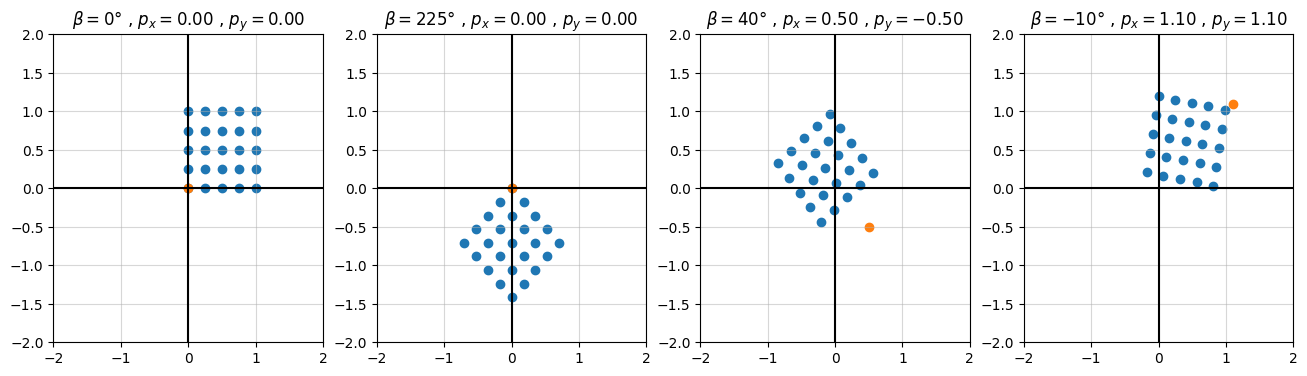

In [ ]:
X, Y = np.mgrid[0:1:5j, 0:1:5j]
x, y = X.ravel(), Y.ravel()
plt.rcParams['figure.figsize'] = (16, 4)

def trans_rotate(x, y, px, py, beta):
    beta = np.deg2rad(beta)
    T = [[np.cos(beta), -np.sin(beta), px*(1 - np.cos(beta)) + py*np.sin(beta)],
         [np.sin(beta),  np.cos(beta), py*(1 - np.cos(beta)) - px*np.sin(beta)],
         [0           ,  0           , 1                                      ]]
    T = np.array(T)
    P = np.array([x, y, [1]*x.size])
    return np.dot(T, P)

fig, ax = plt.subplots(1, 4)

R_ = [0, 225, 40, -10]
P_ = [[0, 0], [0, 0], [0.5, -0.5], [1.1, 1.1]]

print(x)

for i in range(4):
    beta = R_[i]; px, py = P_[i]
    x_, y_, _ = trans_rotate(x, y, px, py, beta)
    ax[i].scatter(x_, y_)
    ax[i].scatter(px, py)
    ax[i].set_title(r'$\beta={0}°$ , $p_x={1:.2f}$ , $p_y={2:.2f}$'.format(beta, px, py))

    ax[i].set_xlim([-2, 2])
    ax[i].set_ylim([-2, 2])
    ax[i].grid(alpha=0.5)
    ax[i].axhline(y=0, color='k')
    ax[i].axvline(x=0, color='k')

plt.show()

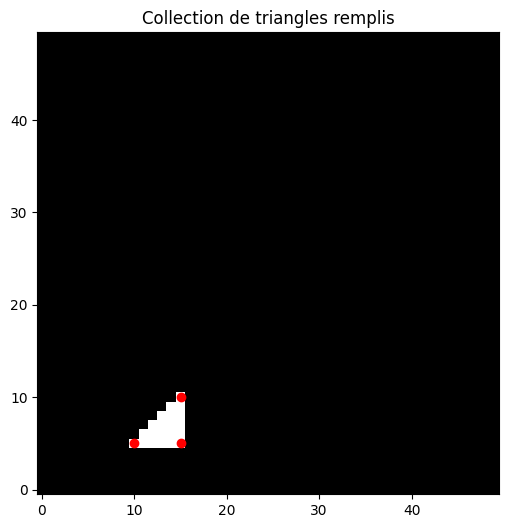

In [ ]:
import numpy as np
from skimage.draw import polygon

MAP_SIZE = 50
occupancy_grid = np.ones((MAP_SIZE, MAP_SIZE), dtype=np.int8) * -1

# Coordonnées des sommets
x = np.array([5, 5, 10])   # Axe vertical (lignes)
y = np.array([10, 15, 15]) # Axe horizontal (colonnes)

# Récupère les indices des pixels dans le triangle
rr, cc = polygon(x, y, occupancy_grid.shape)

# Remplir avec 1
occupancy_grid[rr, cc] = 1


# Affichage
plt.figure(figsize=(6, 6))
plt.imshow(occupancy_grid, cmap="gray", origin="lower")
for (xs,ys) in zip(x,y):
    #xs, ys = zip(*tri)
    plt.scatter(ys, xs, color="red")  # sommets
plt.title("Collection de triangles remplis")
plt.show()